In [25]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

scale = 1;
fsize = (12*scale, 9*scale)
mpl.rcParams['axes.titlesize'] = 26*scale
mpl.rcParams['legend.fontsize'] = 22*scale
mpl.rcParams['axes.labelsize'] = 20*scale
mpl.rcParams['lines.linewidth'] = 2*scale
mpl.rcParams['lines.markersize'] = 16*scale
mpl.rcParams['xtick.labelsize'] = 18*scale
mpl.rcParams['ytick.labelsize'] = 18*scale

def newton_sys(f, jac, x0, tol, max_iter=50):
    x = np.array(x0)
    it = 0
    err = 2*tol
    while it < max_iter and err > tol:
        fx = f(x)
        jacx = jac(x)
        delta = np.linalg.solve(jacx, fx)
        x = x - delta
        it += 1
        err = np.max(np.abs(delta))
    return x, it

def newton(f, df, x0, tol, max_iter=50, tolf=1e-20):
    x = x0
    it = 0
    err = 2*tol
    while it < max_iter and err > tol:
        fx = f(x)
        delta = -fx/df(x)
        x += delta
        it += 1
        err = abs(delta)
    return x, it

def refline(x, y, slope, offset, side=0):
    """ draws a ref line next to data y = Cx^p with
     estimated p = slope, offset by 'offset' decades """
    if side==0:
        base = 0
        ind0 = 0
        ind1 = len(x)//2
    else:
        base = len(x)-1
        ind0 = len(x)//2
        ind1 = len(x)
            
    y = [10**offset*y[base]*(v/x[base])**slope for v in x[ind0:ind1]]
    return x[ind0:ind1], y

## Euler's method(s)

Here we solve the initial value problem
$$y' = f(t,y), \quad y(0) = y_0$$
in the interval $[0,b].$ With a fixed step size $h = b/N$, the **Forward Euler method** computes 
$$u_{n+1} = u_n + hf(t_n,u_n)$$
to obtain an approximation $u_n \approx y(t_n)$ at times $t_n = nh.$

The number of steps is known, but we use a while loop here that takes "one step at a time" and checks if it is done. This allows more generality (e.g. adjusting $h$).

The **Backward Euler method** is

$$u_{n+1} = u_n + hf(t_{n+1},u_{n+1}).$$

To go from time $n$ to $n+1$, one must solve the non-linear equation

$$0 = z - u_n - hf(t_{n+1},z) := G(z)$$

This is done using Newton's method; note that the derivative of $G$ is

$$G'(z) = 1 - \frac{\partial f}{\partial y}(t_{n+1},z)$$

so the method only needs to take $f$ and $\partial f/\partial y$ as inputs.

In [32]:
def fwd_euler(func, b, y0, nsteps):
    """ Forward Euler with fixed step size using a while loop."""
            
    yvals = np.zeros([nsteps+1, 1])
    tvals = np.zeros([nsteps+1, 1])
    h = b/nsteps

    y = y0 
    yvals[0] = y
    t = 0
    it = 0
    while t < b: 
        y += h*func(t, y)
        t += h
        it += 1
        yvals[it] = y
        tvals[it] = t

    return tvals, yvals


def back_euler(func, dfunc, b, y0, nsteps, ntol=1e-10, max_iter=50):
    """ Backward Euler with fixed time step h using a while loop."""

    yvals = np.zeros([nsteps+1, 1])
    tvals = np.zeros([nsteps+1, 1])
    h = b/nsteps

    y = y0
    yvals[0] = y
    t = 0
    it = 0
    while t < b:
        t += h
        nfunc = lambda z: z - h*func(t, z) - y # G(z) for solving G(z) = 0
        df = lambda z: 1 - h*dfunc(t, z) #G'(z)
        y, ncount = newton(nfunc, df, y, ntol, max_iter) #get u_{n+1}
        it += 1
        yvals[it] = y
        tvals[it] = t

    return [tvals, yvals]

#### Error example

The standard error bound for Euler's method in $[0,b]$ is [see lecture notes] 
$$ \max |u_n - y_n| \leq e^{Lb}|u_0 - y_0| + \frac{M}{L}(e^{Lb}-1)h.$$
where $L$ is the max. of $|\partial f/\partial y|$ and $M$ is the max of $|y''(t)|.$ The convergence is first order ($O(h)$).

However, the bound is often pessimistic. Compare the examples below for

$$y' = 2ty, y(0) = 1, \qquad y' = -2ty, y(0) = 1$$
with solutions $y(t) = e^{-t^2}$ and $y(t) = e^{t^2}.$


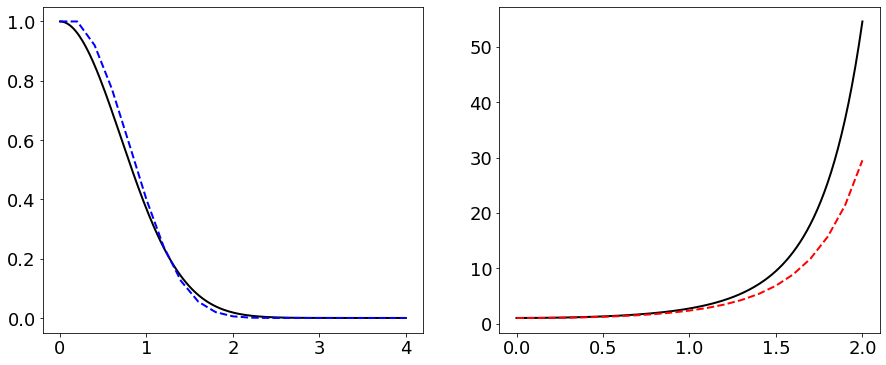

In [33]:
nsteps = 20
T, Y = fwd_euler(lambda t,y: -2*t*y, 4, 1, nsteps)
T2, Y2 = fwd_euler(lambda t,y: 2*t*y, 2, 1, nsteps)

times = np.linspace(0, 4, 200)
times2 = np.linspace(0, 2, 200)
plt.figure(figsize=[fsize[0]*1.25,fsize[1]/1.5])
plt.subplot(121)
plt.plot(times, np.exp(-times**2), '-k', T, Y, '--b')
plt.subplot(122)
plt.plot(times2, np.exp(times2**2), '-k', T2, Y2, '--r');

## Error plots and convergence

The maximum error in $[0,b]$ is

$$E(h) = \max_{0\leq n \leq N} |u_n - y(t_n)|$$
with points $t_0,\cdots,t_N$ spanning the interval and $h = b/N.$

We expect $$E(h) = O(h^p)$$ so a log-log plot is appropriate for plotting $E(h)$ vs. $h$.

Note that the `convergence' like $O(h^p)$ only occurs when $h$ is small enough, indicating that there is more going on [see next section].

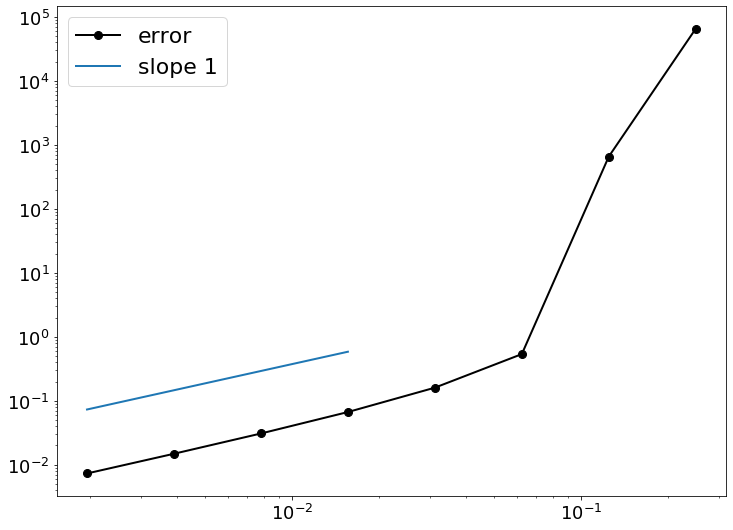

In [34]:
coeff = 20
def odef(t,y): #y' = -C(y - sin(t)) + cos(t)
    return -coeff*(y-np.sin(t)) + np.cos(t)

def exact(t):
    return np.exp(-coeff*t) + np.sin(t)

y0 = 1
b = 2
nvals = [2**p for p in range(3,11)]
hvals = [b/n for n in nvals]

errs = [0]*len(nvals)
for i in range(len(nvals)):
    T, Y = fwd_euler(odef, b, y0, nvals[i])
    errs[i] = max([abs(exact(T[i]) - Y[i]) for i in range(len(T))])

plt.figure(figsize=fsize)
plt.loglog(hvals, errs, '.-k')
x, y = refline(hvals, errs, 1, 1, side=1)
plt.loglog(x,y);
plt.legend(['error','slope 1'])

## Backward Euler, stiff equations

The region of absolute stability [see lecture notes] for Euler's method is $\{z : |1+z| < 1\}$, which includes only $(-2,0)$ on the negative real axis.

On the other hand, the region for Backward Euler is $\{z : |1-z| > 1|\}$, which includes the entire negative real axis.

To have stability for 

$$ y' = -\lambda(y - \sin t) + \cos t, \quad y(0)  = 1,$$

we need $h\lambda$ in the stability region. This requires $h < 2/\lambda$ for Forward Euler. Howevfer, there is no restriction for Backward Euler. 

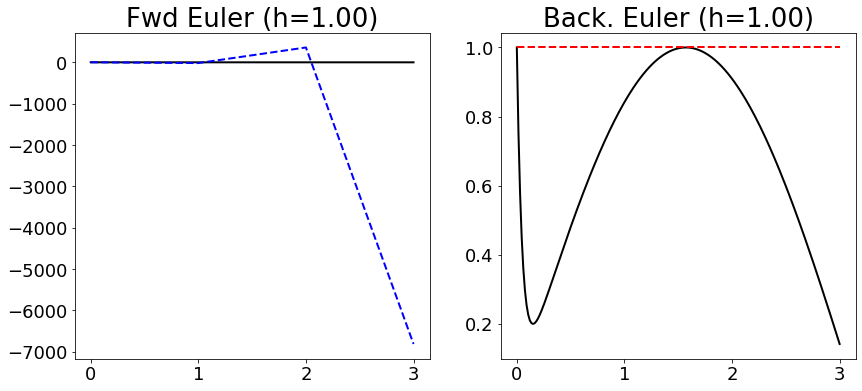

In [11]:
b = 3
coeff = 20
h = 1 #step size; adjust above/below 2/coeff to compare

def odef(t,y): #y' = -C(y - sin(t)) + cos(t)
    return -coeff*(y-np.sin(t)) + np.cos(t)

def ode_df(t,y): #df/dy
    return - coeff

def exact(t):
    return np.exp(-coeff*t) + np.sin(t)

nsteps = int(np.ceil(b/h))
T, Y = fwd_euler(odef, b, 1, nsteps)
T2, Y2 = back_euler(odef, ode_df, b, 1, nsteps)

times = np.linspace(0, 3, 200)
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(times, exact(times), '-k', T, Y, '--b')
plt.title('Fwd Euler (h={:.2f})'.format(h))
plt.subplot(122)
plt.plot(times, exact(times), '-k', T2, Y2, '--r')
plt.title('Back. Euler (h={:.2f})'.format(h));

## First-order systems

A first order system $\vec{y} = F(t,\vec{y})$ (with $\vec{y}(t) : [a,b] \to \mathbb{R}^m$) can be solved using the same methods for scalar equations.

The ODE function is implemented to output a vector $(F_1,F_2,\cdots,F_m)$ of components of $F$. Here, numpy arrays are used so that numpy's vector arithmetic can be used (e.g. $\texttt{x+y}$ to add $\texttt{x=[1,2]}$ and $\texttt{y=[2,3]}$).

The results at times $t_0,\cdots, t_N$ are stored in an $(N+1) \times m$ array of $y$-values.

For Backward Euler, one has to solve the non-linear system

$$0 = G(z) := z - \vec{u}_n - hF(t_{n+1},z)$$

for $z = \vec{u}_{n+1}.$ This is done using Newton's method for systems; the relevant Jacobian is

$$DG_{ij} = I - h\frac{\partial F_i}{\partial y_j}$$

so the function needs the Jacobian of $F$ with respect to $\vec{y}$ as an input. 

In [29]:

def fwd_euler_sys(func, interval, y0, nsteps):
    """ Forward Euler for a system, vectorized with numpy """

    ndim = len(y0)

    a = interval[0]
    b = interval[1]
    yvals = np.zeros([nsteps+1, ndim])
    tvals = np.linspace(a, b, nsteps+1)
    h = (b-a)/nsteps

    y = np.array(y0)  # y at current time, copying y0!
    yvals[0, :] = y
    t = a
    it = 0
    while t < b:
        y += h*func(t, y)
        t += h
        it += 1
        yvals[it, :] = y
        tvals[it] = t

    return tvals, yvals


def back_euler_sys(func, dfunc, interval, y0, nsteps, ntol=1e-10, max_iter=50):
    """ Backward Euler, vectorized with fixed time step h """

    ndim = len(y0)
    a = interval[0]
    b = interval[1]
    yvals = np.zeros([nsteps+1, ndim])
    tvals = np.linspace(a, b, nsteps+1)
    h = (b-a)/nsteps

    y = np.array(y0)  # y at current time, copying y0
    yvals[0, :] = y
    t = a
    it = 0
    while t < b:
        t += h
        nfunc = lambda z: z - h*func(t, z) - y #G(z)
        jac = lambda z: np.eye(ndim) - h*dfunc(t, z) #Jacobian for G(z)
        y, ncount = newton_sys(nfunc, jac, y, ntol, max_iter)
            
        it += 1
        yvals[it, :] = y
        tvals[it] = t

    return [tvals, yvals]

### Example (systems)

We solve the second order IVP
$$y'' + (b+1)y' + by = 0, \quad y(0) = c, \, y'(0) = d$$
by converting to a first order system $\vec{y}' = F(\vec{y})$ for $\vec{y} = (y_1,y_2)$,
$$y_1' = y_2, \qquad y_2' = -by_1 - (b+1)y_2$$
Note that the system may be stiff if $b \gg 1$ since the Jacobian
$$
\frac{\partial F}{\partial \vec{y}} = \begin{bmatrix} 0 & 1 \\ -b & -(b+1)\end{bmatrix}
$$
has eigenvalues $1$ and $b$. When $b$ is large, Backward Euler will perform better.

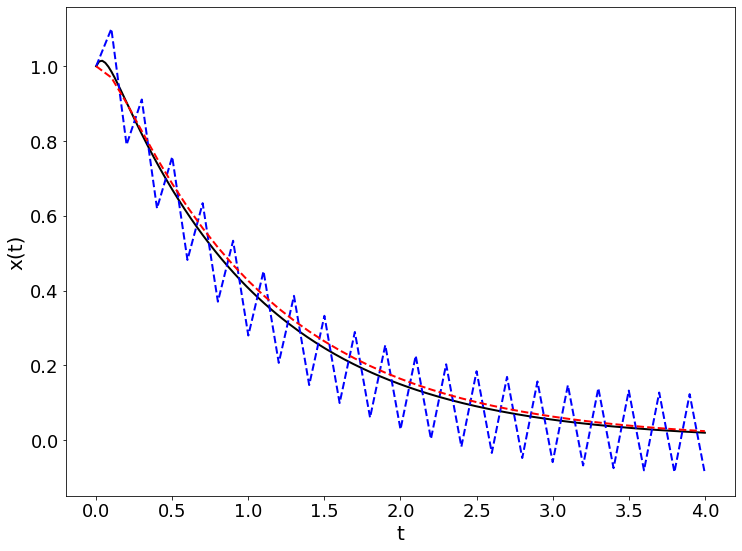

In [41]:
#Example: second order ODE y'' + (b+1)y' + by = 0 with solutions c1e^(-t) + c2e^(-bt)
#as a first order system: y_1' = y_2, y_2' = -by_1 - (b+1)y_2
coeff = 20
y0 = np.array([1.0, 1.0]) #IC [y(0) y'(0)]
h = 0.1

def dfunc_ode3(t, y): #dF/dy
    return np.array([ [0, 1], [-coeff, -(coeff+1)] ])

def ode3(t, y): #f(t.y)
    return np.array([y[1], -coeff*y[0]-(coeff+1)*y[1]])

def exact_ode3(t): #exact solution y(t) given [y(0), y'(0)]
    c2 = (y0[0] + y0[1])/(1-coeff)
    c1 = y0[0] - c2
    return c1*np.exp(-t) + c2*np.exp(-coeff*t)

b = 4.0
nsteps = int(np.ceil(b/h))

T, Y = fwd_euler_sys(ode3, [0, b], y0, nsteps)
T2, Y2 = back_euler_sys(ode3, dfunc_ode3, [0, b], y0, nsteps)

times = np.linspace(0, b, 200)
plt.figure(figsize=fsize)
plt.plot(times, exact_ode3(times), '-k')
plt.plot(T, Y[:, 0], '--b')
plt.plot(T2, Y2[:, 0], '--r')
plt.xlabel('t')
plt.ylabel('x(t)');